# Tenencia del producto préstamo en el DataSet de Banco Checo  

Vamos a intentar extraer del datset generado que variables son las más relevantes para que una cuenta (account) tenga un péstamo (loan) y ver si de esta forma podemos generar un customer journey para conseguir que un cliente contrate un préstamo

In [1]:
import pandas as pd
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Cargamos los datos que hemos procesado en R
df_original= pd.read_csv("C://Master Data Science/Master en Data Science/TFM/Transacciones de Banco Checo/DFTenenciaProductos2.csv")

In [3]:
#Comenzamos a revisar que el DF se haya importado correctamente
df_original.shape

(4500, 70)

In [4]:
df_original.head()

,Unnamed: 0,district_id,account_id,frequency,Date_Account,client_id_owner,client_id_disponent,sex_owner,birth_owner,sex_disponent,...,Num_Sym_Pension,Num_Sym_Insurance,Num_Sym_NegBal,Num_Sym_Household,Num_Sym_Statement,Num_Sym_IntDep,Num_Sym_LoanPayment,Balance_in_negative,account_disponent_bin,account_loan_bin
0,1,1,1938,Monthly,1994-06-25,2354,NaN,M,1967-12-21,NaN,...,0,0,0,50,49,54,0,0,0,0
1,2,1,1562,Monthly,1995-08-30,1894,NaN,F,1947-11-05,NaN,...,0,0,0,36,35,36,0,0,0,0
2,3,1,7099,Monthly,1996-08-20,8568,NaN,F,1971-12-03,NaN,...,0,24,0,24,23,28,7,0,0,1
3,4,1,2316,Monthly,1997-07-21,2802,NaN,F,1966-11-29,NaN,...,0,0,0,13,12,17,0,0,0,0
4,5,1,1570,Monthly,1994-03-12,1903,NaN,F,1939-08-30,NaN,...,57,0,0,53,52,53,0,0,0,0


In [5]:
# Vamos a analizar si hay missings al cargar los datos a Python
df_original.columns[df_original.isnull().sum()!=0]
#Vemos que las variables con missings provienen de variables que ya tenían esos missings en el DataFrame generado con R,
#ya que el disponent (autorizado), los préstamos y las tarjetas no son productos que tengan asociados todas las cuentas  

Index(['client_id_disponent', 'sex_disponent', 'birth_disponent', 'loan_id',
       'Date_Loan', 'Amount_Loan', 'Duration_Loan', 'Payments_Loan', 'status',
       'Status_Loan', 'owner_card_date'],
      dtype='object')

In [6]:
#Vemos como se han importado las variables del DataFrame de R al DataFrame que vamos a utilizar en Python 
print(df_original.iloc[:,0:32].dtypes)
print(df_original.iloc[:,31:61].dtypes)
print(df_original.iloc[:,60:70].dtypes)
#Observamos que las variables de factor y de fecha han modificado su tipo de variable, 
#por lo que tendremos que trabajar con ellas

Unnamed: 0                        int64
district_id                       int64
account_id                        int64
frequency                        object
Date_Account                     object
client_id_owner                   int64
client_id_disponent             float64
sex_owner                        object
birth_owner                      object
sex_disponent                    object
birth_disponent                  object
loan_id                         float64
Date_Loan                        object
Amount_Loan                     float64
Duration_Loan                   float64
Payments_Loan                   float64
status                           object
Status_Loan                      object
Ord_Insurance                     int64
Ord_Insurance_amount              int64
Ord_Household_Payment             int64
Ord_Household_Payment_amount      int64
Ord_Loan_Payment                  int64
Ord_Loan_Payment_amount         float64
Ord_Leasing                       int64


In [7]:
#Transformamos a formato fecha las variables que originalmente eran fecha en R
df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]]=df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]].apply(pd.to_datetime)
from datetime import datetime
df_original['Date_Account']=df_original['Date_Account'].apply(datetime.toordinal)
df_original['birth_owner']=df_original['birth_owner'].apply(datetime.toordinal)
df_original['birth_disponent']=df_original['birth_disponent'].apply(datetime.toordinal)
df_original['Date_Loan']=df_original['Date_Loan'].apply(datetime.toordinal)
df_original['owner_card_date']=df_original['owner_card_date'].apply(datetime.toordinal)

In [8]:
#De todas las variables de las que disponemos, vamos a seleccionar las que vamos a utilizar en este ejercicio:

#La  variable que vamos a predecir va a ser "account_loan_bin" y por tanto la denominaremos "y"

#Para este ejercicio no consideramos las variables que hemos obtenido en el mismo fichero que la variable a predecir (loan.csv):
#loan_id, Date_Loan, Amount_Loan, Duration_Loan, Payments_Loan, status, Status_Loan.

#Otras variables que no consideramos: account_id, client_id_owner, client_id_disponent, district ID y unnamed:0 porque 
#son ID's descriptivas sin información para utilizar

#La variable disponent_card_type no aporta información

#Otras variables que no consideramos:district_name, region (nombre). Utilizamos el resto de la información de variables 
#del fichero district.csv

#Haciendo referencia a district.csv , la información de crimes_95, crimes_96 y entrepreneurs la vamos a utilizar como ratio,
#ya que como veremos a continuación, de esta forma obtendremos menos impacto por un distrito con mucha población (Praga) 



In [9]:
#Las variables crimes_95, crimes_96 y entrepreneurs vamos a utilizarlas en formato ratio, tal y como calculamos en R

(array([3443.,  240.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <a list of 10 Patch objects>)

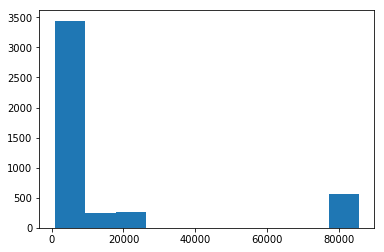

In [10]:
plt.hist(df_original['crimes_95'])

(array([ 596., 1052.,  499.,  760.,  370.,  317.,  128.,  224.,    0.,
         554.]),
 array([0.01354271, 0.01929884, 0.02505497, 0.0308111 , 0.03656723,
        0.04232336, 0.04807949, 0.05383562, 0.05959176, 0.06534789,
        0.07110402]),
 <a list of 10 Patch objects>)

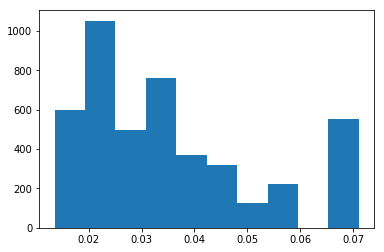

In [11]:
plt.hist(df_original['crimes_95_ratio'])

(array([3683.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  888. , 10709.9, 20531.8, 30353.7, 40175.6, 49997.5, 59819.4,
        69641.3, 79463.2, 89285.1, 99107. ]),
 <a list of 10 Patch objects>)

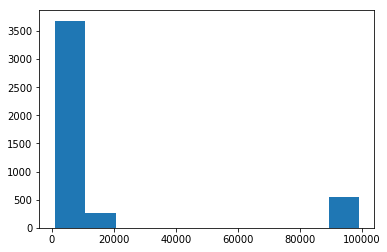

In [12]:
plt.hist(df_original['crimes_96'])

(array([1141.,  804.,  726.,  637.,  415.,   88.,  135.,    0.,    0.,
         554.]),
 array([0.0159461 , 0.02257646, 0.02920682, 0.03583717, 0.04246753,
        0.04909789, 0.05572825, 0.06235861, 0.06898896, 0.07561932,
        0.08224968]),
 <a list of 10 Patch objects>)

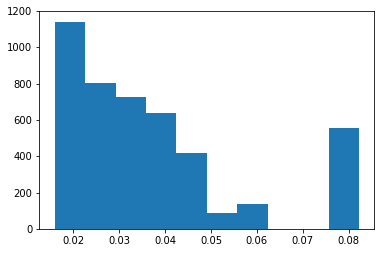

In [13]:
plt.hist(df_original['crimes_96_ratio'])

(array([200., 354., 644., 992., 517., 757., 259., 138.,  85., 554.]),
 array([ 81. ,  89.6,  98.2, 106.8, 115.4, 124. , 132.6, 141.2, 149.8,
        158.4, 167. ]),
 <a list of 10 Patch objects>)

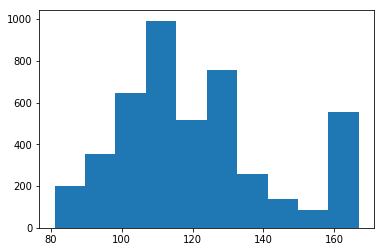

In [14]:
plt.hist(df_original['entrepreneurs'])

(array([ 969.,  322., 1256.,  793.,  312.,  388.,  177.,  192.,   43.,
          48.]),
 array([0.00013859, 0.00041431, 0.00069003, 0.00096575, 0.00124147,
        0.00151719, 0.0017929 , 0.00206862, 0.00234434, 0.00262006,
        0.00289578]),
 <a list of 10 Patch objects>)

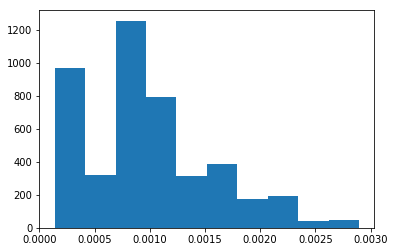

In [15]:
plt.hist(df_original['entrepreneurs_ratio'])

In [16]:
#Creamos un DataFrame con las variables que vamos a considerar numéricas
df_num=df_original[['Date_Account','birth_owner', 'birth_disponent','owner_card_date','Ord_Insurance', 'Ord_Insurance_amount',
                    'Ord_Household_Payment','Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
                    'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499', 'municip 500-1999',
                    'municip 2000-9999', 'municip > 10000', 'num_cities', 'avg_salary',  
                    'Num_Type_Credit', 'Num_Type_VYBER', 'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
                    'Num_Op_Collection','Num_Op_CashCredit', 'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard',
                    'Num_Sym_Null', 'Num_Sym_Null2','Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
                    'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep', 'Num_Sym_LoanPayment', 
                    'Balance_in_negative','Ord_Loan_Payment_amount', 'Ord_Leasing_amount','ratio_urban_inhabitants',
                    'unemployment_rate_95','unemployment_rate_96', 'crimes_95_ratio', 'crimes_96_ratio', 'entrepreneurs_ratio' ]] 

In [17]:
#Creamos un DataFrame con las variables que vamos a considerar categóricas
df_cat=df_original[['account_disponent_bin','frequency', 'sex_owner', 'owner_card_type',
       'sex_disponent']]
#Vemos que tipos tienen las variables que queremos que sean categóricas
df_cat.dtypes

account_disponent_bin     int64
frequency                object
sex_owner                object
owner_card_type           int64
sex_disponent            object
dtype: object

In [18]:
#Ponemos las variables "owner_card_type" y "account_disponent_bin" como string para poder obtener dummies
df_cat["owner_card_type"]=df_cat["owner_card_type"].astype(str)
df_cat["account_disponent_bin"]=df_cat["account_disponent_bin"].astype(str)

C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df_cat_dumm=pd.get_dummies(df_cat)

In [20]:
df_cat_dumm.dtypes
#Al pasar a dummies las variables, hemos incrementado en 8 el número total de variables

account_disponent_bin_0    uint8
account_disponent_bin_1    uint8
frequency_After_trans      uint8
frequency_Monthly          uint8
frequency_Weekly           uint8
sex_owner_F                uint8
sex_owner_M                uint8
owner_card_type_0          uint8
owner_card_type_1          uint8
owner_card_type_2          uint8
owner_card_type_3          uint8
sex_disponent_F            uint8
sex_disponent_M            uint8
dtype: object

In [21]:
df = pd.concat([df_num, df_cat_dumm], axis = 1)
df.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Loan_Payment,Ord_Leasing,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,728104,718421,1,1,0,0,1,6646,0,1,...,1,0,0,1,1,0,0,0,0,0
1,728535,711070,1,1,0,0,1,1933,0,0,...,1,0,1,0,1,0,0,0,0,0
2,728891,719864,1,1,1,528,1,236,1,0,...,1,0,1,0,1,0,0,0,0,0
3,729226,718034,1,1,0,0,1,2111,0,0,...,1,0,1,0,1,0,0,0,0,0
4,727999,708081,1,1,0,0,1,2865,0,0,...,1,0,1,0,1,0,0,0,0,0


# Vamos a generar un primer modelo benchmark

In [22]:
#Antes de probar con modelos vamos a ver si reduciendo dimensionalidad conseguimos una primera intuición

In [23]:
X = df
y = df_original["account_loan_bin"] 

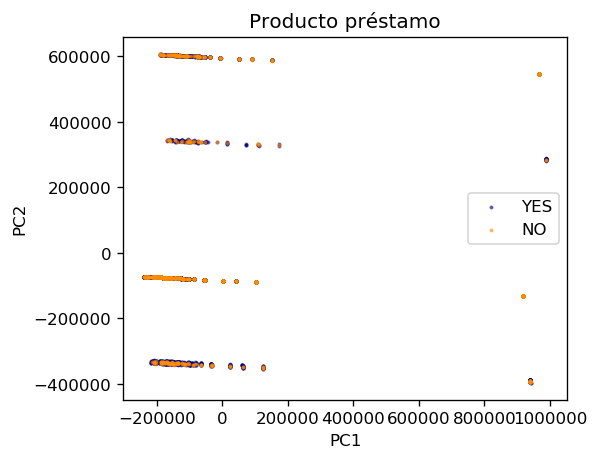

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X)
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='YES', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='NO', s=2, color='darkorange')
plt.legend()
plt.title('Producto préstamo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

In [154]:
#Del gráfico anterior no consigo sacar nada en claro
pca2 = PCA(n_components=2)
pca2.fit(X)
print(pca2.components_)
print(pca2.explained_variance_ratio_)
#De los componentes una intuición de que quizás las variables 3 ('birth_disponent'),4 ('owner_card_date') y 
#13 'num_inhabitants' podrían ser importantes

[[-1.41899145e-05  3.76112969e-04  2.97418890e-02  6.65291847e-02
   1.10456611e-08  6.97541426e-05 -8.13236480e-09  4.49340526e-05
   1.92086580e-09  1.51642509e-08  1.86478704e-08  1.40767450e-04
   9.97335487e-01 -4.90984072e-05 -2.32177716e-05 -5.72845134e-06
  -5.87189940e-07 -5.04538511e-06  3.32207470e-03  2.80449536e-06
   4.49809421e-07  3.59443953e-06  1.27687280e-06  5.86459693e-07
  -1.80003778e-06  3.32766034e-06  2.90427567e-06  5.53513591e-07
   3.95002345e-06  7.30692726e-07 -9.05250243e-07  3.92910956e-07
   9.53161761e-08  5.39244984e-07  4.59238406e-07  1.27687280e-06
   3.09695048e-07  3.58832264e-07  4.66633456e-05  4.45604444e-05
   3.74408574e-05 -2.48007137e-06 -2.94393181e-06  3.92241114e-08
   4.83722236e-08 -1.07124667e-09 -4.19281050e-08  4.19281050e-08
  -4.73145522e-09 -5.56504707e-09  1.02965023e-08  3.63305616e-09
  -3.63305616e-09 -9.12049432e-08  6.41757903e-08  4.74961153e-09
   2.22795413e-08  2.15292322e-08  2.03988728e-08]
 [ 3.04437369e-06  3.7370

In [29]:
#Pasamos a hacer modelos sencillos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
#Probamos una Regresión logística
clf_LR=LogisticRegression()
clf_LR.fit(X_train,y_train)

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
def eval_modelo (clf,X_train,y_train, X_test,y_test):
    print("Datos de train:")
    print("El accuracy es",accuracy_score(y_train,clf.predict(X_train))*100,"%")
    print("La precision es",precision_score(y_train,clf.predict(X_train))*100, "%")
    print("El recall es",recall_score(y_train,clf.predict(X_train))*100,"%")
    tn, fp, fn, tp=confusion_matrix(y_train,clf.predict(X_train)).ravel()
    print("tn:",tn," fp:",fp," fn:",fn," tp:",tp)
    print("Datos de test:")
    print("El accuracy es",accuracy_score(y_test,clf.predict(X_test))*100,"%")
    print("La precision es",precision_score(y_test,clf.predict(X_test))*100, "%")
    print("El recall es",recall_score(y_test,clf.predict(X_test))*100,"%")
    tn_t, fp_t, fn_t, tp_t=confusion_matrix(y_test,clf.predict(X_test)).ravel()
    print("tn:",tn_t," fp:",fp_t," fn:",fn_t," tp:",tp_t)      

In [32]:
eval_modelo(clf_LR,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 97.25 %
La precision es 95.64315352697096 %
El recall es 85.52875695732838 %
tn: 3040  fp: 21  fn: 78  tp: 461
Datos de test:
El accuracy es 96.66666666666667 %
La precision es 94.48818897637796 %
El recall es 83.91608391608392 %
tn: 750  fp: 7  fn: 23  tp: 120


In [76]:
#Probamos con un árbol de decisión
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5)
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
eval_modelo(clf_tree,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 3061  fp: 0  fn: 0  tp: 539
Datos de test:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 757  fp: 0  fn: 0  tp: 143


In [37]:
#Los resultados de estos modelos tan sencillos están siendo extraordinarios. Vamos a investigar las razones.
#Además como las clases están desbalanceadas vamos a ir comparando el efecto de incluir oversampling o no.

<function matplotlib.pyplot.show(*args, **kw)>

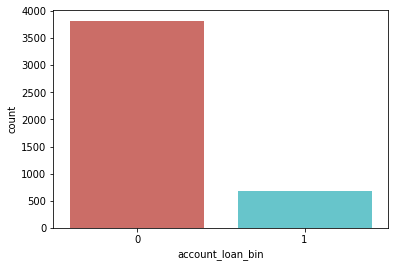

In [41]:
#Las clases a predecir de train (si la cuenta tiene prestamo=1 ó no tiene =0) están desbalanceadas
y2=pd.DataFrame(y)
sns.countplot(x="account_loan_bin",data=y2, palette='hls')
plt.show

In [39]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [36]:
#Función para dibujar un árbol
def dibu_arb(tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(Image(graph.create_png()))
    

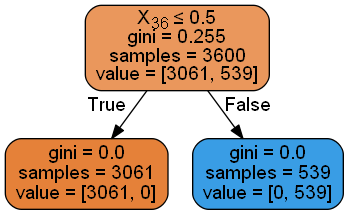

In [40]:
dibu_arb(clf_tree)

In [42]:
X_train.columns[36]
#Parece que la variable 'Num_Sym_LoanPayment' contiene toda la información "account_loan_bin", 
#aunque se han extraido de ficheros distintos

'Num_Sym_LoanPayment'

In [43]:
#Vamos a aplicar oversampling con el algoritmo SMOTE y vamos a ver si cambian las métricas

In [44]:
# conda install -c glemaitre imbalanced-learn

In [45]:
from imblearn.over_sampling import SMOTENC

In [48]:
#Pra ver las columnas que vamos a denominar como categóricas  cuando apliquemos SMOTE
print(X_train.columns)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
       'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Num_Sym_LoanPayment', 'Balance_in_negative', 'Ord_Loan_Payment_amount',
       'Ord_Leasing_amount', 'ratio_urban_inhabitants', 'unemployment_rate_95',
       'unemployment_rate_96', 'crimes_95_ratio', 'crimes_

In [49]:
smo=SMOTENC(categorical_features=range(46,59),random_state=0)
os_X,os_y=smo.fit_sample(X_train, y_train)
columns = X_train.columns
os_X = pd.DataFrame(data=os_X,columns=columns)
os_y= pd.DataFrame(data=os_y,columns=['account_loan_bin'])

In [50]:
#Chequeamos que SMOTENC funciona como esperábamos

print("length of oversampled data is ",len(os_X))
print("Number of loans=0 in oversampled data",len(os_y[os_y['account_loan_bin']==0]))
print("Number of loans=1",len(os_y[os_y['account_loan_bin']==1]))
print("Proportion of loans=0 is ",len(os_y[os_y['account_loan_bin']==0])/len(os_X))
print("Proportion of loans=1 is ",len(os_y[os_y['account_loan_bin']==1])/len(os_X))

os_bin=os_X[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
print("unique de variables categóricas",unique(os_bin))
print("unique de variable y",unique(os_y))

length of oversampled data is  6122
Number of loans=0 in oversampled data 3061
Number of loans=1 3061
Proportion of loans=0 is  0.5
Proportion of loans=1 is  0.5
unique de variables categóricas [0. 1.]
unique de variable y [0 1]


In [54]:
clf_tree_os=clf_tree.fit(os_X,os_y)

In [56]:
eval_modelo(clf_tree_os,os_X,os_y, X_test, y_test)
#Obtenemos los mismos resultados con y sin SMOTE. Lógicamente porque estamos suponiendo que la variable 
#'Num_Sym_LoanPayment' contiene la información de si la cuenta tiene un préstamo o no

Datos de train:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 3061  fp: 0  fn: 0  tp: 3061
Datos de test:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 757  fp: 0  fn: 0  tp: 143


In [53]:
#Vemos que tener un préstamo correlaciona de forma muy significativa con las variables:Ord_Loan_Payment,Num_Sym_LoanPayment y 
#Ord_Loan_Payment_amount
df_original.corr()["account_loan_bin"]

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [128]:
#Vemos las correlaciones de las variables anteriores
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Loan_Payment"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Loan_Payment_amount"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Sym_LoanPayment"]))

[[1.         0.97080682]
 [0.97080682 1.        ]]
[[1.         0.83143262]
 [0.83143262 1.        ]]
[[1.        0.8227983]
 [0.8227983 1.       ]]


In [69]:
#Vamos a ver qué resultados obtenemos eliminando la variable 'Num_Sym_LoanPayment'
X1=X.drop(['Num_Sym_LoanPayment'], axis=1)

In [70]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=0)

In [85]:
clf_treeX1=clf_tree.fit(X1_train,y1_train)

Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


In [86]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(45,58),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X1,os_y1=smo.fit_sample(X1_train, y1_train)
columns = X1_train.columns
os_X1 = pd.DataFrame(data=os_X1,columns=columns)
os_y1= pd.DataFrame(data=os_y1,columns=['account_loan_bin'])

In [89]:
clf_tree_osX1=clf_tree.fit(os_X1,os_y1)

In [90]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX1,X1_train,y1_train, X1_test, y1_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX1,os_X1,os_y1, X1_test, y1_test)

Sin Oversampling
Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140
Con Oversampling
Datos de train:
El accuracy es 99.73864750081673 %
La precision es 99.64134333224649 %
El recall es 99.83665468801046 %
tn: 3050  fp: 11  fn: 5  tp: 3056
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


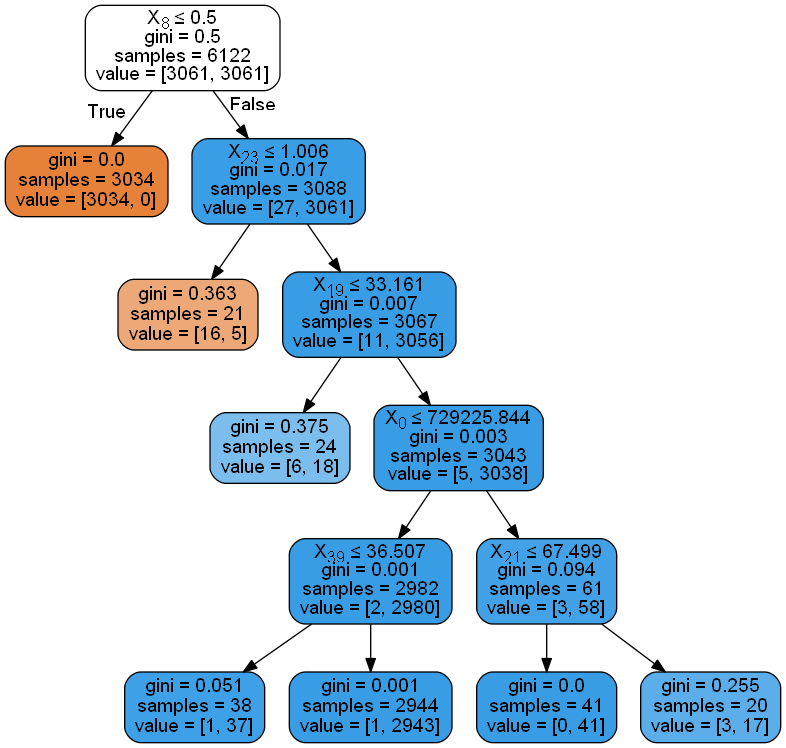

In [91]:
dibu_arb(clf_treeX1)

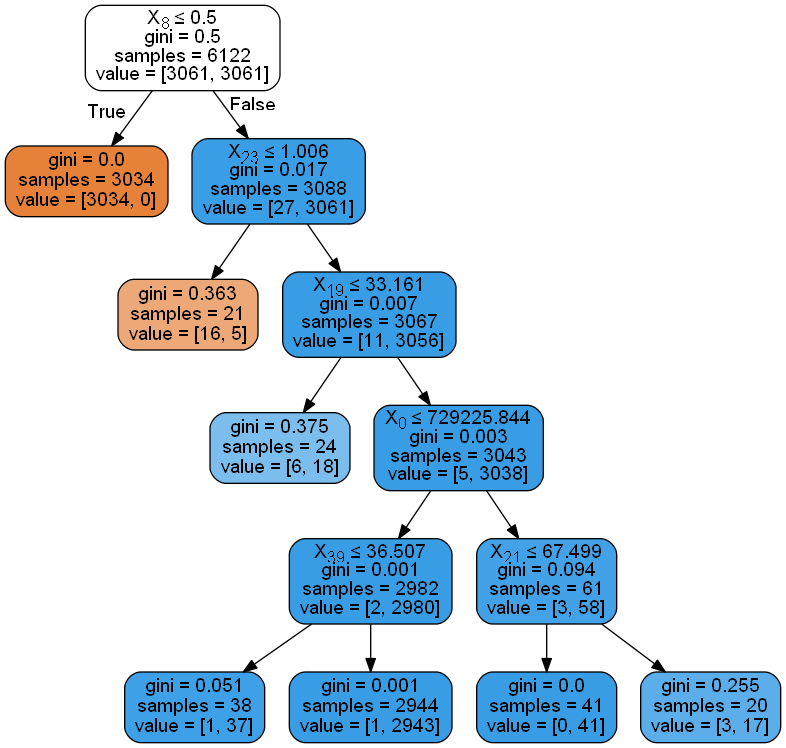

In [92]:
dibu_arb(clf_tree_osX1)

In [105]:
X1_train.columns[8]

'Ord_Loan_Payment'

In [94]:
#El modelo continua dando unos resultados espectaculares, vamos a ver que sucede si eliminamos la variable 'Ord_Loan_Payment'

In [95]:
X2=X1.drop(['Ord_Loan_Payment'], axis=1)

In [97]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=0)

In [98]:
clf_treeX2=clf_tree.fit(X2_train,y2_train)

In [99]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(44,57),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X2,os_y2=smo.fit_sample(X2_train, y2_train)
columns = X2_train.columns
os_X2 = pd.DataFrame(data=os_X2,columns=columns)
os_y2= pd.DataFrame(data=os_y2,columns=['account_loan_bin'])

In [100]:
clf_tree_osX2=clf_tree.fit(os_X2,os_y2)

In [101]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX2,X2_train,y2_train, X2_test, y2_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX2,os_X2,os_y2, X2_test, y2_test)

Sin Oversampling
Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140
Con Oversampling
Datos de train:
El accuracy es 99.73864750081673 %
La precision es 99.64134333224649 %
El recall es 99.83665468801046 %
tn: 3050  fp: 11  fn: 5  tp: 3056
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


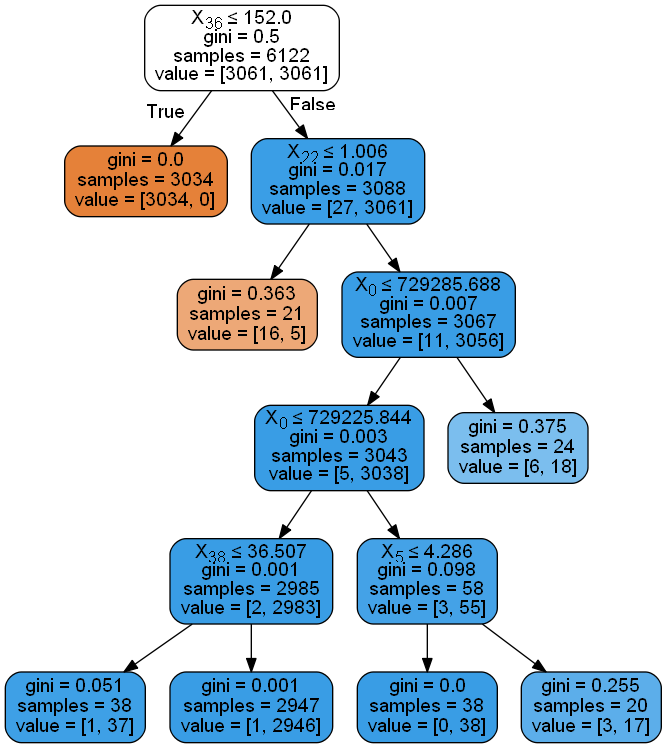

In [102]:
dibu_arb(clf_treeX2)

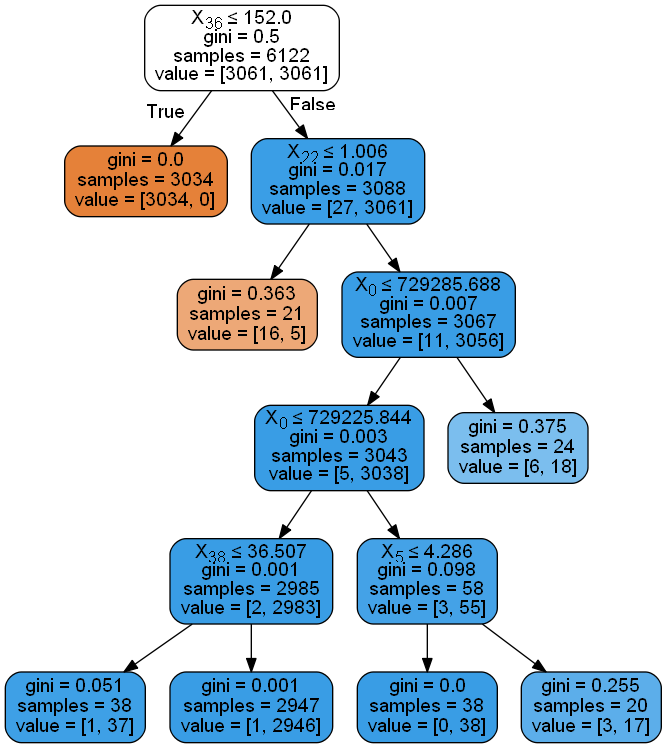

In [103]:
dibu_arb(clf_tree_osX2)

In [107]:
X2_train.columns[36]

'Ord_Loan_Payment_amount'

In [109]:
#El modelo continua dando resultados espectaculares, vamos a ver que sucede si eliminamos la variable Ord_Loan_Payment_amount

In [155]:
X3=X2.drop(['Ord_Loan_Payment_amount'], axis=1)

In [158]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=0)

In [159]:
clf_treeX3=clf_tree.fit(X3_train,y3_train)

In [160]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(43,56),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X3,os_y3=smo.fit_sample(X3_train, y3_train)
columns = X3_train.columns
os_X3 = pd.DataFrame(data=os_X3,columns=columns)
os_y3= pd.DataFrame(data=os_y3,columns=['account_loan_bin'])

In [161]:
clf_tree_osX3=clf_tree.fit(os_X3,os_y3)

In [162]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX3,os_X3,os_y3, X3_test, y3_test)

Sin Oversampling
Datos de train:
El accuracy es 92.13888888888889 %
La precision es 73.44322344322345 %
El recall es 74.39703153988869 %
tn: 2916  fp: 145  fn: 138  tp: 401
Datos de test:
El accuracy es 89.55555555555556 %
La precision es 66.66666666666666 %
El recall es 68.53146853146853 %
tn: 708  fp: 49  fn: 45  tp: 98
Con Oversampling
Datos de train:
El accuracy es 92.1920940868997 %
La precision es 94.95301079011486 %
El recall es 89.12120222149625 %
tn: 2916  fp: 145  fn: 333  tp: 2728
Datos de test:
El accuracy es 89.55555555555556 %
La precision es 66.66666666666666 %
El recall es 68.53146853146853 %
tn: 708  fp: 49  fn: 45  tp: 98


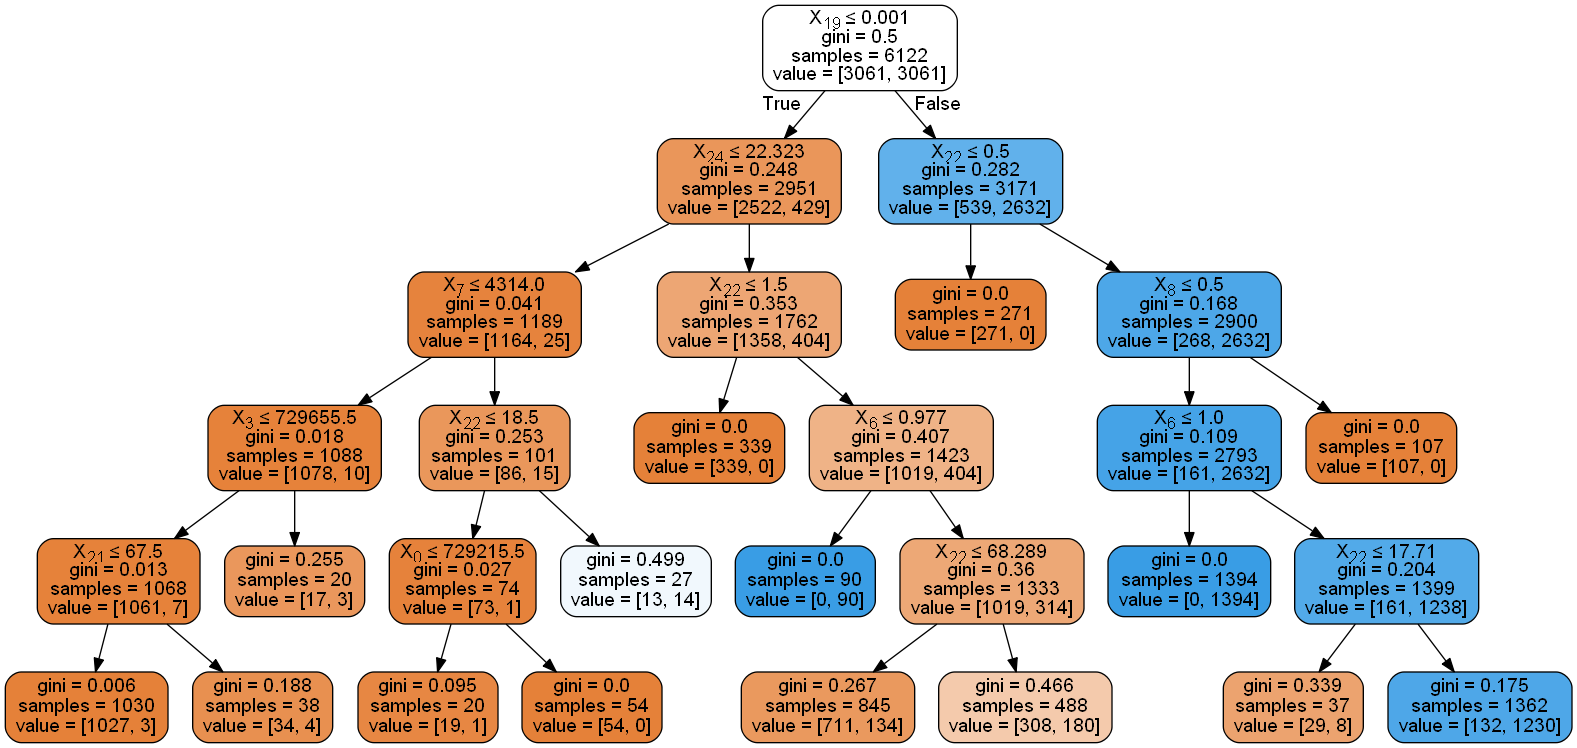

In [115]:
dibu_arb(clf_treeX3)

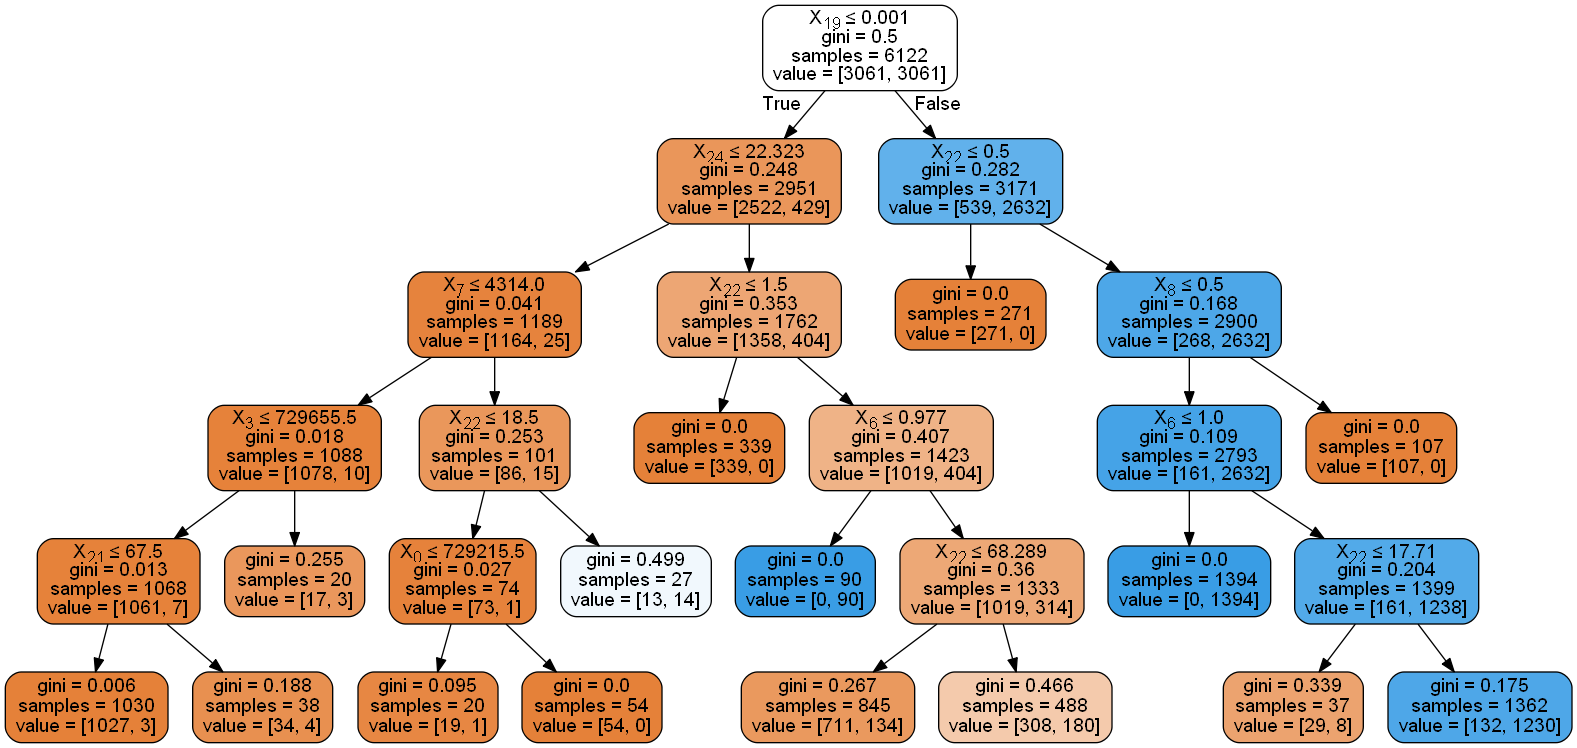

In [116]:
dibu_arb(clf_tree_osX3)

In [121]:
#Vemos cuales son las variables más relevantes
print(X3_train.columns[19])#Número de un tipo especial de reintegros
print(X3_train.columns[24])#Número de ingresos en efectivo
print(X3_train.columns[22])#Número de transferencias enviadas
print(X3_train.columns[6])#Número de pagos relacionados con el hogar
print(X3_train.columns[7])#Importe de pagos relacionados con el hogar
print(X3_train.columns[8])#Número de pagos por Leasing

Num_Type_VYBER
Num_Op_CashCredit
Num_Op_Remittances
Ord_Household_Payment
Ord_Household_Payment_amount
Ord_Leasing


In [130]:
#Vemos las correlaciones de estas variables con la tenencia de préstamo
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Type_VYBER"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Op_CashCredit"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Op_Remittances"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Household_Payment"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Household_Payment_amount"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Leasing"]))


[[1.         0.28989446]
 [0.28989446 1.        ]]
[[1.         0.10026035]
 [0.10026035 1.        ]]
[[1.         0.13851467]
 [0.13851467 1.        ]]
[[ 1.         -0.11510295]
 [-0.11510295  1.        ]]
[[1.         0.06508002]
 [0.06508002 1.        ]]
[[ 1.         -0.12101995]
 [-0.12101995  1.        ]]


In [122]:
#Vemos cuales son las variables más relevantes (de otra forma). Coincide con el análisis anterior
clf_treeX3.feature_importances_

array([3.14036522e-05, 0.00000000e+00, 0.00000000e+00, 3.47692636e-04,
       0.00000000e+00, 0.00000000e+00, 5.03630023e-02, 1.54406782e-03,
       7.87652632e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.16672318e-01,
       0.00000000e+00, 3.30428828e-04, 2.25444137e-01, 0.00000000e+00,
       2.65016868e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [124]:
clf_tree_osX3.feature_importances_==clf_treeX3.feature_importances_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [126]:
print(df_original.corr()["account_loan_bin"])

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [131]:
#Después de eliminar las variables que más suenan a préstamo, vamos a ver que sucede si eliminamos la variable Num_Type_VYBER.
#Esta variable se corresponde con un tipo especial de reintegros

In [132]:
X4=X3.drop(['Num_Type_VYBER'], axis=1)

In [133]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.2, random_state=0)

In [134]:
clf_treeX4=clf_tree.fit(X4_train,y4_train)

In [135]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(42,55),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X4,os_y4=smo.fit_sample(X4_train, y4_train)
columns = X4_train.columns
os_X4 = pd.DataFrame(data=os_X4,columns=columns)
os_y4= pd.DataFrame(data=os_y4,columns=['account_loan_bin'])

In [136]:
clf_tree_osX4=clf_tree.fit(os_X4,os_y4)

In [137]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX4,X4_train,y4_train, X4_test, y4_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX4,os_X4,os_y4, X4_test, y4_test)

Sin Oversampling
Datos de train:
El accuracy es 84.66666666666667 %
La precision es 49.19454770755886 %
El recall es 73.65491651205936 %
tn: 2651  fp: 410  fn: 142  tp: 397
Datos de test:
El accuracy es 83.55555555555556 %
La precision es 48.78048780487805 %
El recall es 69.93006993006993 %
tn: 652  fp: 105  fn: 43  tp: 100
Con Oversampling
Datos de train:
El accuracy es 86.0829794184907 %
La precision es 86.4641795972268 %
El recall es 85.56027442012414 %
tn: 2651  fp: 410  fn: 442  tp: 2619
Datos de test:
El accuracy es 83.55555555555556 %
La precision es 48.78048780487805 %
El recall es 69.93006993006993 %
tn: 652  fp: 105  fn: 43  tp: 100


# ¿La precision parece que sea al azar?. No estamos overfitteando porque el Oversampling que estamos haciendo precisamente mejora la precision en train

# ¿Puedo considerar que el oversampling no me está aportando nada?

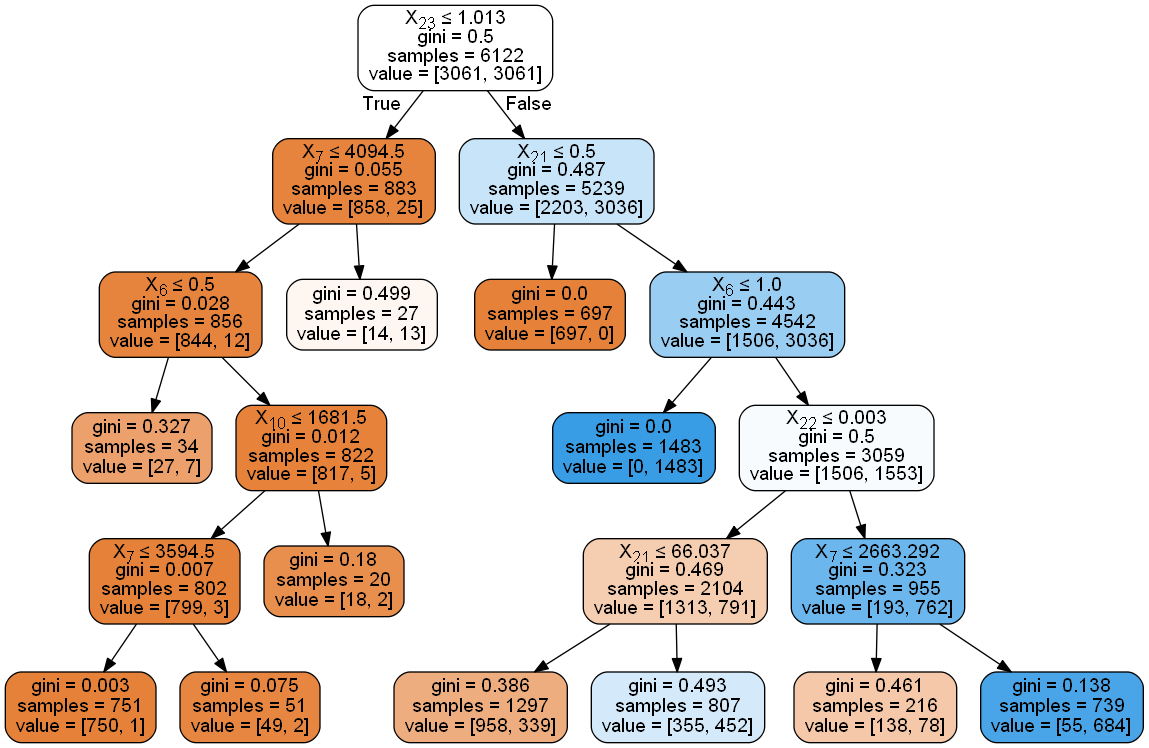

In [138]:
dibu_arb(clf_tree_osX4)

In [139]:
print(X4_train.columns[23])#Número de un tipo especial de reintegros
print(X4_train.columns[7])#Número de ingresos en efectivo
print(X4_train.columns[21])#Número de transferencias enviadas
print(X4_train.columns[6])#Número de pagos relacionados con el hogar
print(X4_train.columns[22])#Importe de pagos relacionados con el hogar
print(X4_train.columns[10])#Número de pagos por Leasing

#Las variables que seguimos obteniendo como más relevantes son las mismas que en el caso anterior

Num_Op_CashCredit
Ord_Household_Payment_amount
Num_Op_Remittances
Ord_Household_Payment
Num_Op_Collection
Ord_Empty_amount


# Me quedo con el DataSet X3 no elimino la variable Num_Type_VYBER

# Las variables que me están saliendo como significativas no parecen aportar mucho

# Vamos a hacer scaling y a ver como cambia el modelo.

In [148]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
columns = X3.columns
X3_scale = rbs.fit_transform(X3)
X=pd.DataFrame(X3_scale,columns=columns)

In [143]:
X.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,-0.534615,0.468801,0.0,0.0,0.0,0.0,0.0,0.908203,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.120192,-0.268345,0.0,0.0,0.0,0.0,0.0,-0.115195,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.222115,0.613502,0.0,0.0,1.0,528.0,0.0,-0.483687,0.0,1.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.544231,0.429993,0.0,0.0,0.0,0.0,0.0,-0.076543,0.0,2.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.635577,-0.568076,0.0,0.0,0.0,0.0,0.0,0.087183,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
X.shape

(4500, 56)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [151]:
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [163]:
#Evaluamos los modelos
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.13888888888889 %
La precision es 73.44322344322345 %
El recall es 74.39703153988869 %
tn: 2916  fp: 145  fn: 138  tp: 401
Datos de test:
El accuracy es 89.55555555555556 %
La precision es 66.66666666666666 %
El recall es 68.53146853146853 %
tn: 708  fp: 49  fn: 45  tp: 98
Con Scaling
Datos de train:
El accuracy es 87.13888888888889 %
La precision es 69.38775510204081 %
El recall es 25.231910946196663 %
tn: 3001  fp: 60  fn: 403  tp: 136
Datos de test:
El accuracy es 85.88888888888889 %
La precision es 64.81481481481481 %
El recall es 24.475524475524477 %
tn: 738  fp: 19  fn: 108  tp: 35
